<a href="https://colab.research.google.com/github/rishabhshah13/Adversarial_Patch_XAI590/blob/main/Assignment%2010/Assignment%2010.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torchcam grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.1 MB/s eta 0:00:00
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39588 sha256=ac9423150ef1aaf35952113e25875b36fb4b10710cc941d9bbc13a3aa8fd7e69
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [6]:
!wget "https://upload.wikimedia.org/wikipedia/commons/3/34/Labrador_on_Quantock_%282175262184%29.jpg" -O "Labrador.jpg"

--2024-11-14 05:48:56--  https://upload.wikimedia.org/wikipedia/commons/3/34/Labrador_on_Quantock_%282175262184%29.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 981091 (958K) [image/jpeg]
Saving to: ‘Labrador.jpg’

Labrador.jpg        100%[===================>] 958.10K  4.34MB/s    in 0.2s    

2024-11-14 05:48:57 (4.34 MB/s) - ‘Labrador.jpg’ saved [981091/981091]



In [7]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchcam.methods import SmoothGradCAMpp, GradCAM, ScoreCAM, SSCAM, XGradCAM, LayerCAM
from torchcam.utils import overlay_mask
from pytorch_grad_cam import GradCAM as PyGradCAM, GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image

# ## Loading Pre-trained Model
# Load a pre-trained ResNet-50 model and set it to evaluation mode
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.eval()

# ## Image Preprocessing
# Define a function to load and preprocess the input image for the model

def load_image(image_path):
    img = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform(img).unsqueeze(0), np.array(img)

# Update the image path with the correct path to your local image
image_path = '/content/Labrador.jpg'
input_tensor, original_image = load_image(image_path)

# ## Initialize CAM Methods with torchcam
# Using SmoothGradCAM++ and GradCAM to generate overlay images
target_layer = 'layer4'
cam_methods = {
    'SmoothGradCAM++': SmoothGradCAMpp(model, target_layer),
}

# Generate and visualize CAM overlays
for name, cam_extractor in cam_methods.items():
    out = model(input_tensor)
    activation_map = cam_extractor(out.argmax().item(), out)
    result = overlay_mask(to_pil_image(original_image), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.5)

# Set target layers for Grad-CAM
target_layers = [model.layer4[-1]]
py_cam = PyGradCAM(model=model, target_layers=target_layers)

# Generate Grad-CAM output for the target class
grayscale_cam = py_cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(208)])[0]  # 208 is class index for 'Labrador retriever'

# Resize original image to (224, 224) to match CAM dimensions
original_image_resized = np.array(Image.fromarray(original_image).resize((224, 224))).astype(np.float32) / 255
cam_image = show_cam_on_image(original_image_resized, grayscale_cam, use_rgb=True)

# ## Guided Backpropagation
# Initialize Guided Backpropagation with pytorch-grad-cam
gb_model = GuidedBackpropReLUModel(model=model, device='cuda')

# Generate Guided Backpropagation output
gb = gb_model(input_tensor, target_category=208)
# gb = gb.transpose((1, 2, 0))  # Transpose to HxWxC format
gb = deprocess_image(gb)  # Convert to a displayable format

# ## Combining Grad-CAM and Guided Backpropagation for Guided Grad-CAM
# Expand grayscale CAM to 3 channels to match Guided Backpropagation dimensions
grayscale_cam = np.repeat(grayscale_cam[:, :, np.newaxis], 3, axis=2)
guided_grad_cam = deprocess_image(gb * grayscale_cam)


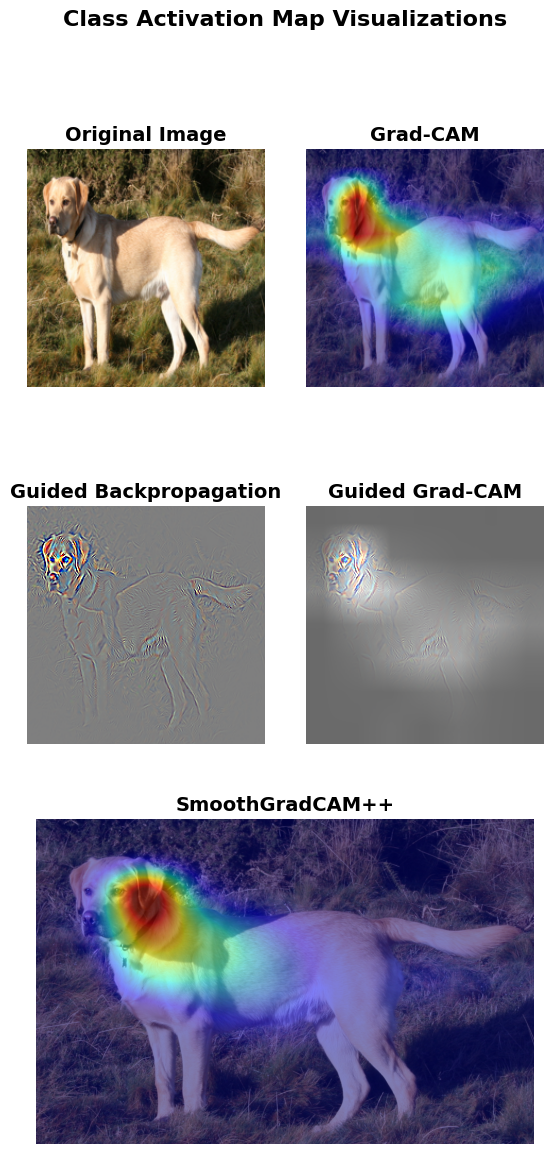

In [8]:
# Set up a figure with a custom layout and spacing
fig = plt.figure(figsize=(6, 12))

# Original Image
ax1 = fig.add_subplot(3, 2, 1)
ax1.imshow(original_image_resized)
ax1.set_title('Original Image', fontsize=14, fontweight='bold')
ax1.axis('off')

# Grad-CAM
ax2 = fig.add_subplot(3, 2, 2)
ax2.imshow(cam_image)
ax2.set_title('Grad-CAM', fontsize=14, fontweight='bold')
ax2.axis('off')

# Guided Backpropagation
ax3 = fig.add_subplot(3, 2, 3)
ax3.imshow(gb)
ax3.set_title('Guided Backpropagation', fontsize=14, fontweight='bold')
ax3.axis('off')

# Guided Grad-CAM
ax4 = fig.add_subplot(3, 2, 4)
ax4.imshow(guided_grad_cam)
ax4.set_title('Guided Grad-CAM', fontsize=14, fontweight='bold')
ax4.axis('off')

# Center SmoothGradCAM++ in the last row
ax5 = fig.add_subplot(3, 1, 3)  # Centered across the entire bottom row
ax5.imshow(result)
ax5.set_title('SmoothGradCAM++', fontsize=14, fontweight='bold')
ax5.axis('off')

# Adjust layout and add an overall title
plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.9)
fig.suptitle('Class Activation Map Visualizations', fontsize=16, fontweight='bold')

# Show the figure
plt.show()
